# Speckle Analysis Script

## Script Parameters

In [5]:
output_path = 'C:/Users/u0119446/Desktop/Temp/Ongoing_projects/Laura/Analysis'
qupath_measurements = 'C:/Users/u0119446/Desktop/Temp/Ongoing_projects/Laura/Qupath/measurements.csv'
description_file = 'C:/Users/u0119446/Desktop/Temp/Ongoing_projects/Laura/Dataset_description_corrected.csv'
object_classifier = 'MecP2_enhanced' # If it is anything other than 'None' this will be used to filter speckles by classification

## Libraries import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Importing csvs

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv(qupath_measurements)

# Read the CSV description file into a DataFrame
df_description = pd.read_csv(description_file)

# Merge df1 and df2 on 'id'
merged_df = pd.merge(df, df_description, on='Image', how='left')

## Preprocessing: Selection of classified speckles and dataframe correction
### Only if an object classifier was used

In [9]:
if object_classifier != 'None':
    # Filter out from merged_df every row that is not Classification MecP2_enhanced
    filtered_df = merged_df[merged_df['Classification'] == object_classifier]

### Preprocessing to drop any empty values and to homogenize WT when having the incorrect writing

In [10]:
filtered_df = filtered_df.dropna()
filtered_df['Genotype'] = filtered_df['Genotype'].str.replace('WT ', 'WT')

## Area histogram generation per condition per region

In [13]:
def prepare_prism_data(data, region, feature):
    """
    Prepares data for Prism by generating histograms for each animal within a specified region and feature.

    Parameters:
    - data (pd.DataFrame): The input data containing 'Region', 'Genotype', 'Animal', and the specified feature.
    - region (str): The region to filter the data on.
    - feature (str): The feature to create histograms for.

    Returns:
    - result_total (pd.DataFrame): DataFrame containing histogram counts for each animal.
    - result_normalized (pd.DataFrame): DataFrame containing normalized histogram counts for each animal.
    """
    # Filter data for the specific region
    region_data = data[data['Region'] == region]

    # Determine the range of the data
    min_value = np.floor(region_data[feature].min())
    max_value = np.ceil(region_data[feature].max())

    # Create bins with 1 µm² increments
    bins = np.arange(min_value, max_value + 1, 1)

    # Initialize the result dataframes for total and normalized counts
    result_total = pd.DataFrame()
    result_normalized = pd.DataFrame()

    # Iterate through each genotype
    for genotype in ['WT', 'KO']:
        genotype_data = region_data[region_data['Genotype'] == genotype]

        # Group data by 'Animal' and iterate
        for animal, animal_data in genotype_data.groupby('Animal'):
            hist, _ = np.histogram(animal_data[feature], bins=bins)
            column_name = animal  # Use the animal identifier as the column name
            result_total[column_name] = hist
            result_normalized[column_name] = hist / len(animal_data)

    # Set index to represent bin ranges
    bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
    result_total['Bin_labels'] = bin_labels
    result_normalized['Bin_labels'] = bin_labels

    return result_total, result_normalized

# Assuming you have your data in a DataFrame called 'filtered_df'
# with columns 'Region', 'Genotype', 'Animal', and 'Area µm^2'

# Prepare data for cerebellum
cerebellum_total, cerebellum_normalized = prepare_prism_data(filtered_df, 'Cerebellum', 'Area µm^2')

# Prepare data for substantia nigra
substantia_nigra_total, substantia_nigra_normalized = prepare_prism_data(filtered_df, 'Substantia Nigra', 'Area µm^2')

# Obtain the output paths
output_path_cerebellum_total = os.path.join(output_path, 'cerebellum_total_counts.xlsx')
output_path_cerebellum_normalized = os.path.join(output_path, 'cerebellum_normalized_counts.xlsx')
output_path_substantia_nigra_total = os.path.join(output_path, 'substantia_nigra_total_counts.xlsx')
output_path_substantia_nigra_normalized = os.path.join(output_path, 'substantia_nigra_normalized_counts.xlsx')

# Save to CSV files
cerebellum_total.to_excel(output_path_cerebellum_total, index=False)
cerebellum_normalized.to_excel(output_path_cerebellum_normalized, index=False)
substantia_nigra_total.to_excel(output_path_substantia_nigra_total, index=False)
substantia_nigra_normalized.to_excel(output_path_substantia_nigra_normalized, index=False)

print("Data preparation for Prism completed. Excel files have been generated.")

Data preparation for Prism completed. Excel files have been generated.


## Exploratory Analysis

### Check the distribution of length and area per animal per region per genotype

In [ ]:
# Function to create frequency distribution plots
def plot_frequency_distribution(data, feature, group_col, group_val, ax):
    sns.histplot(data=data, x=feature, kde=True, ax=ax)
    ax.set_title(f"{feature} Distribution - {group_col}: {group_val}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")
    print(f"Plot created for {group_val}")

# Features to analyze
features = ['Length µm', 'Area µm^2']

# Group by Genotype, Region, and Animal
grouped = filtered_df.groupby(['Genotype', 'Region', 'Animal'])
print(f"Number of groups: {len(grouped)}")

# Create plots for each Genotype-Region combination
for feature in features:
    print(f"Processing feature: {feature}")
    genotypes = filtered_df['Genotype'].unique()
    regions = filtered_df['Region'].unique()
    print(f"Unique Genotypes: {genotypes}")
    print(f"Unique Regions: {regions}")

    fig, axes = plt.subplots(len(genotypes), len(regions), figsize=(20, 15))
    fig.suptitle(f"Frequency Distributions of {feature} by Genotype and Region")

    for i, genotype in enumerate(genotypes):
        for j, region in enumerate(regions):
            print(f"Processing Genotype: {genotype}, Region: {region}")
            ax = axes[i, j] if len(genotypes) > 1 and len(regions) > 1 else axes[i] if len(genotypes) > 1 else axes[j] if len(regions) > 1 else axes

            # Get data for this Genotype-Region combination
            # Iterate over the animals for the specific genotype and region
            animals = filtered_df[(filtered_df['Genotype'] == genotype) & (filtered_df['Region'] == region)]['Animal'].unique()
            print(f"Animals for this combination: {animals}")

            for animal in animals:
                try:
                    data = grouped.get_group((genotype, region, animal))
                    print(f"Data shape for {genotype}-{region}-{animal}: {data.shape}")
                    # Plot frequency distribution
                    plot_frequency_distribution(data, feature, f"Genotype-Region-Animal", f"{genotype}-{region}-{animal}", ax)
                except KeyError:
                    print(f"No data for combination: {genotype}-{region}-{animal}")

    plt.tight_layout()
    plt.savefig(f"{feature.replace(' ', '_')}_distribution.png")
    print(f"Figure saved: {feature.replace(' ', '_')}_distribution.png")
    plt.show()
    plt.close()

print("Script execution completed.")

### Check the distribution per condition and region of different features

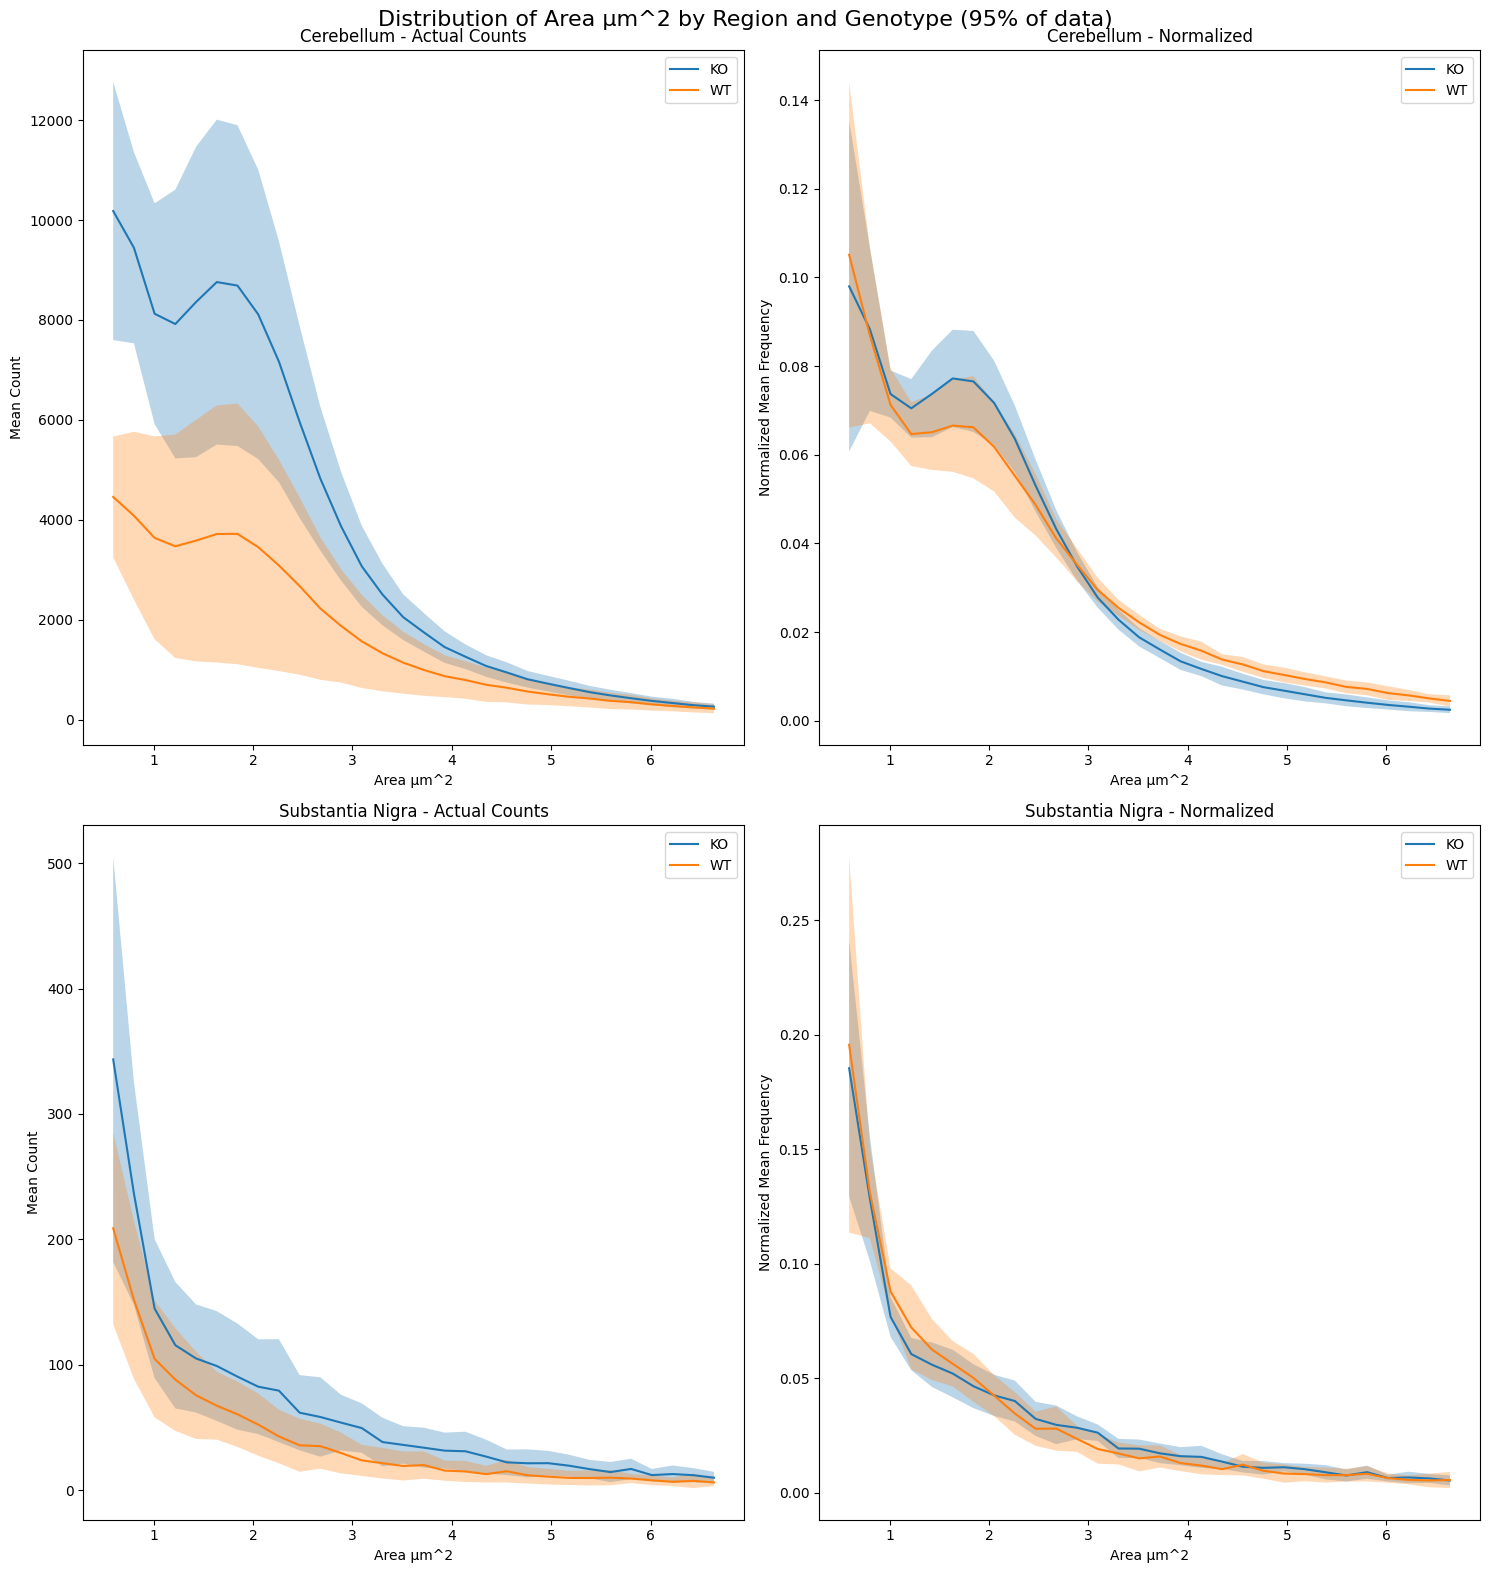

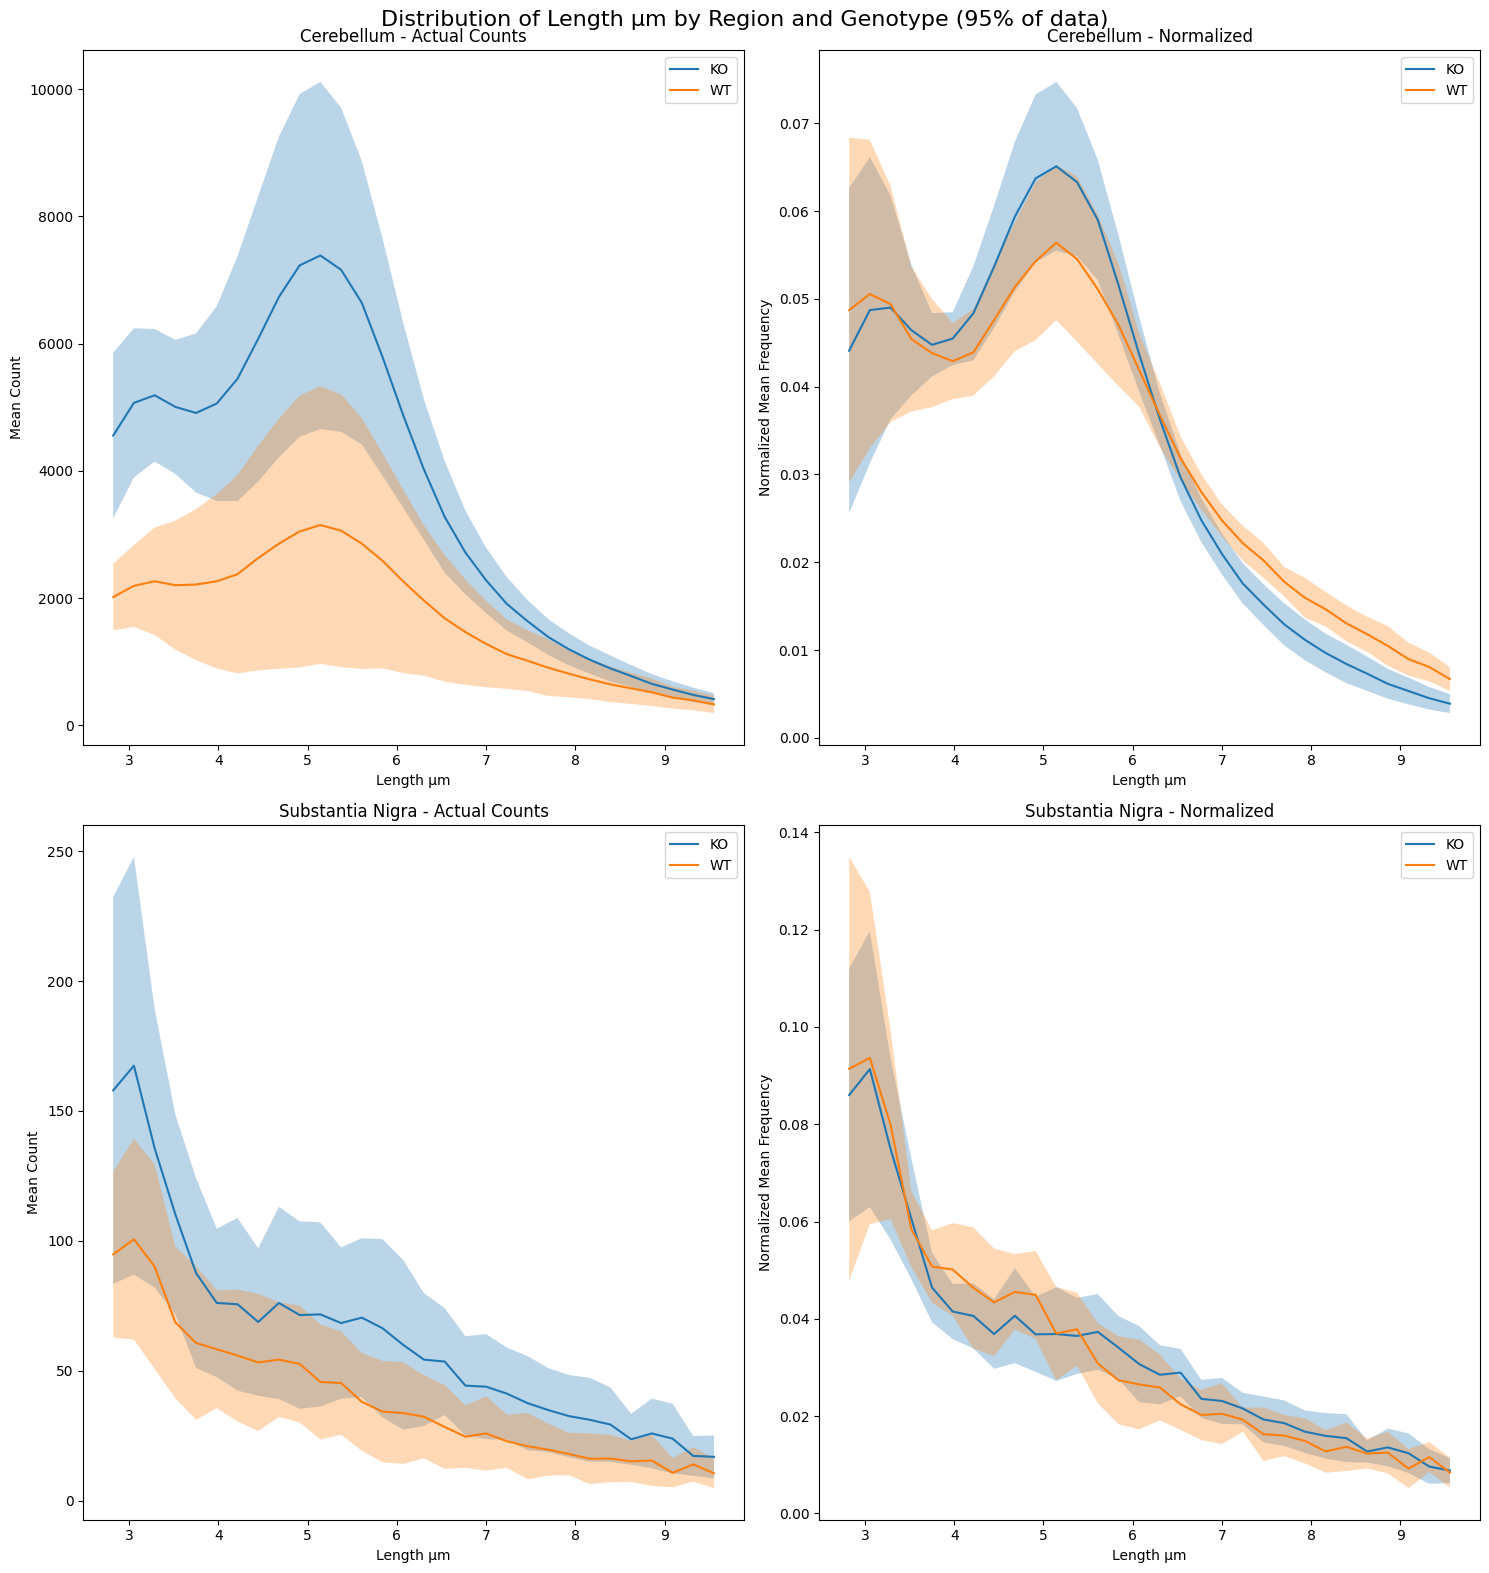

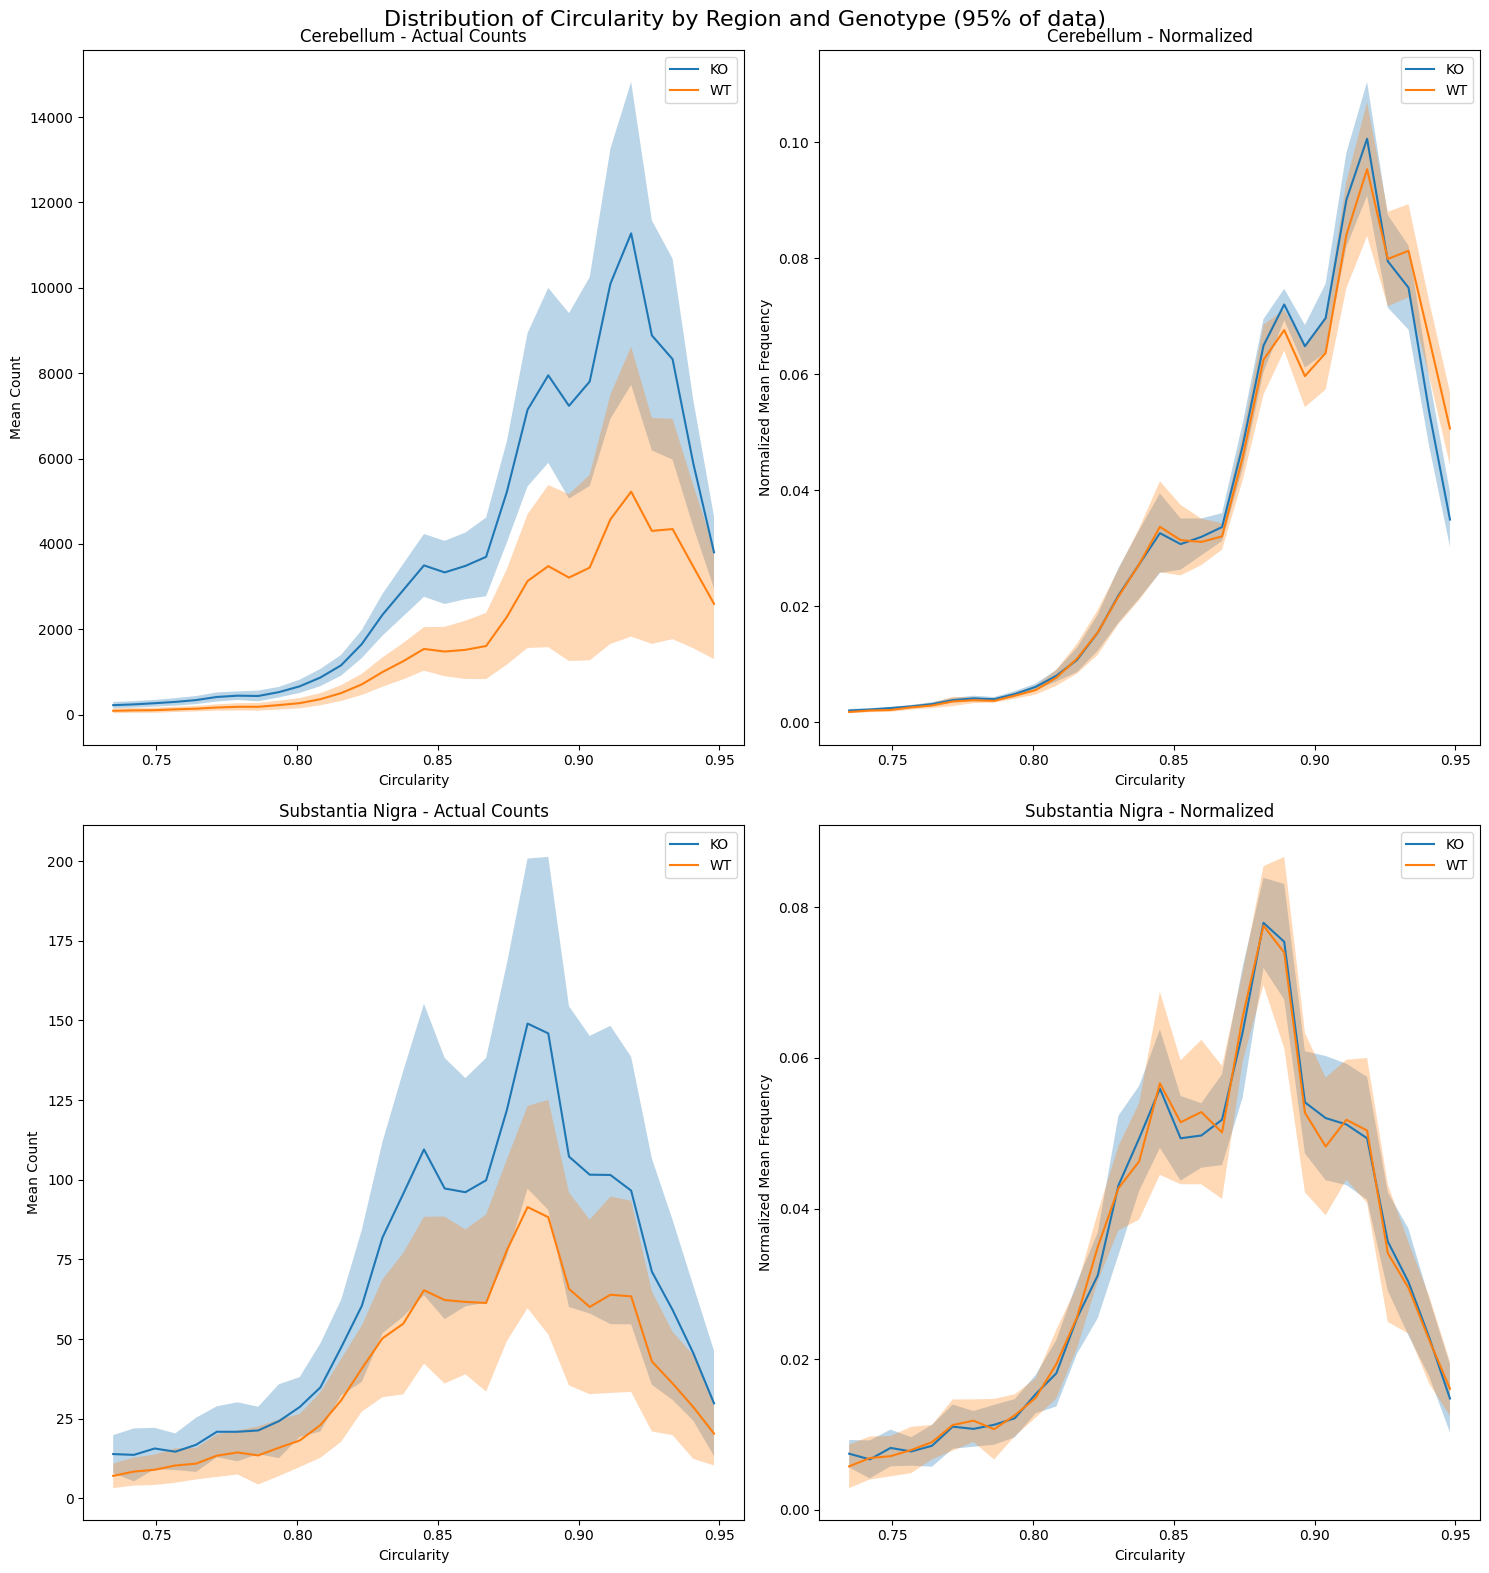

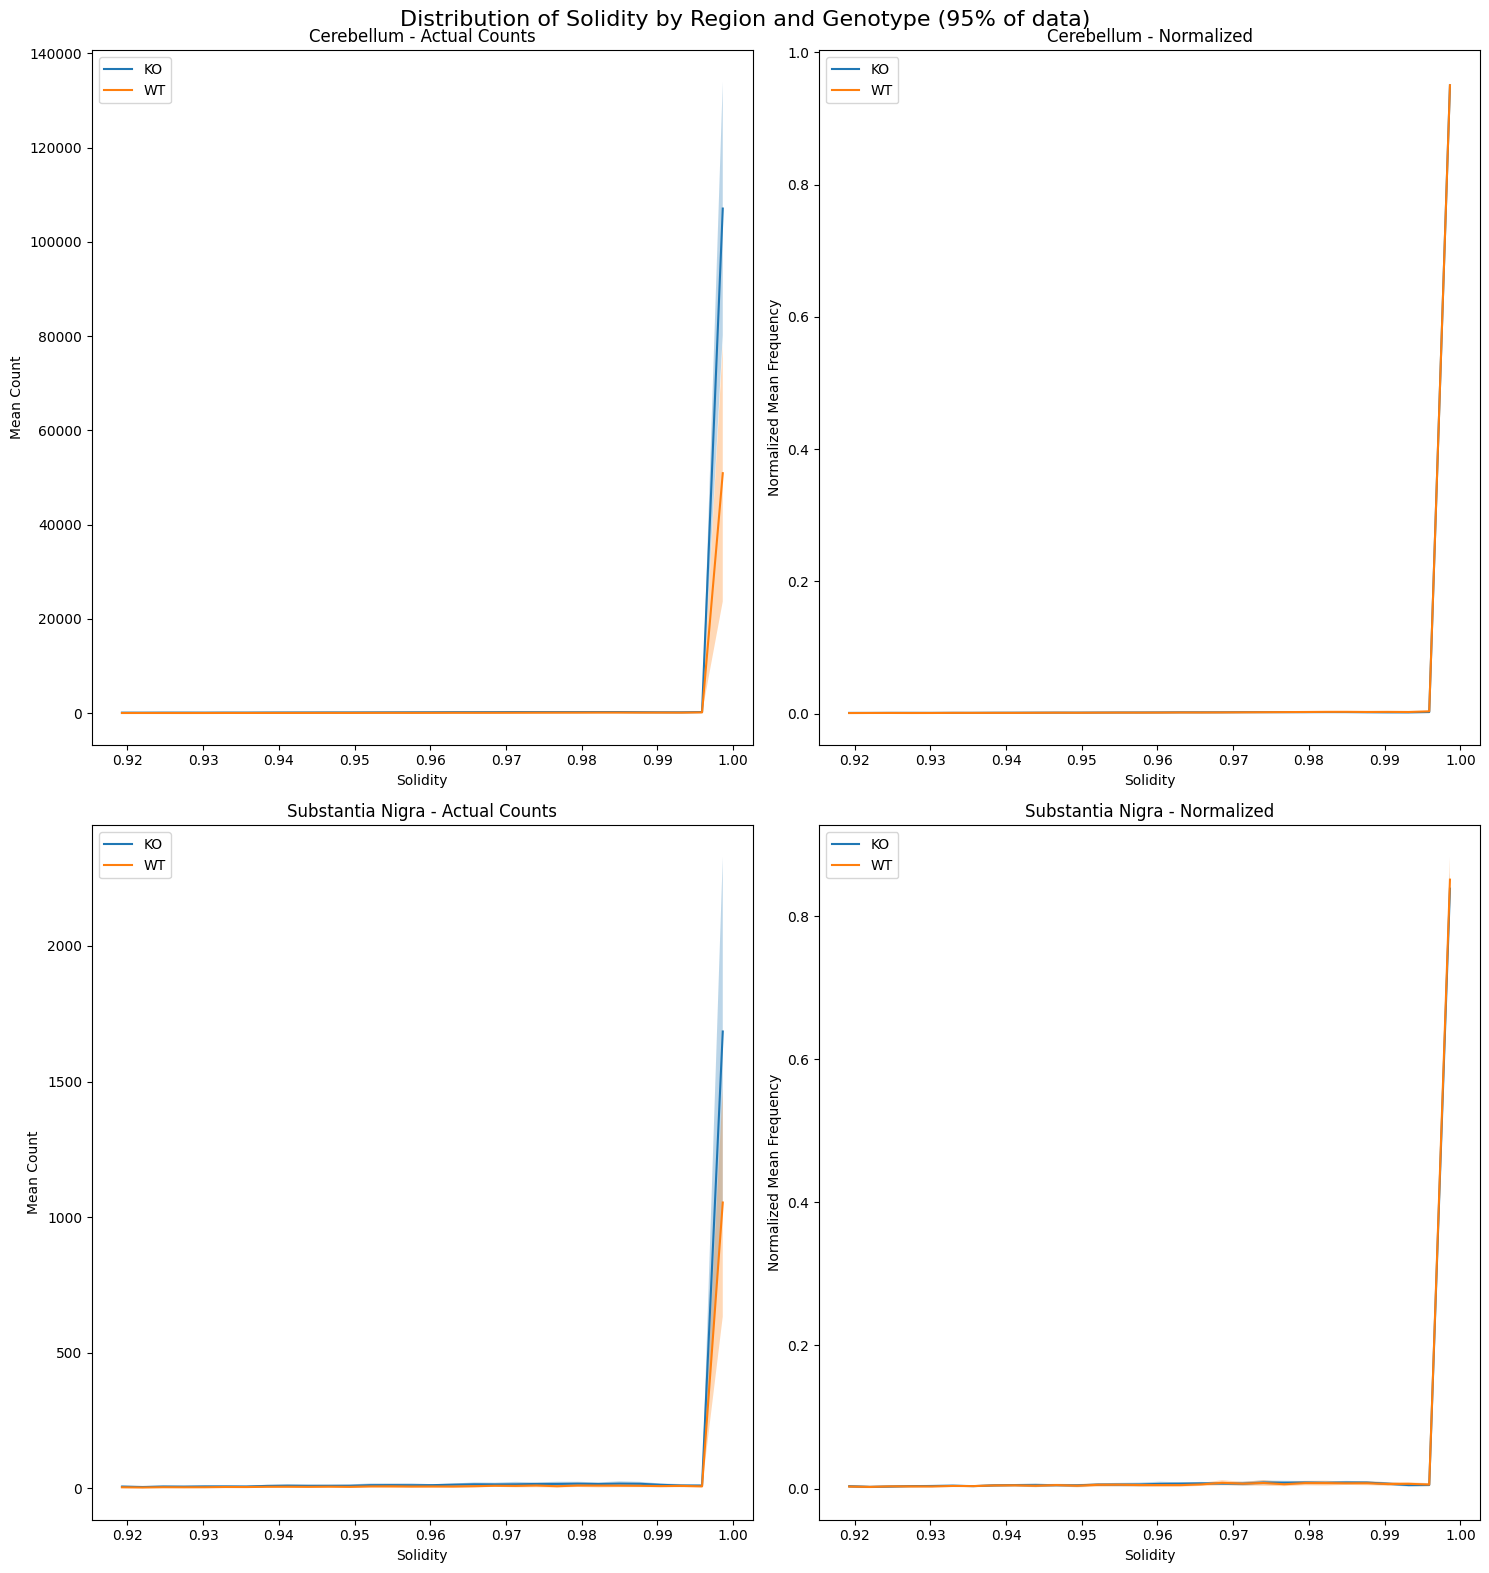

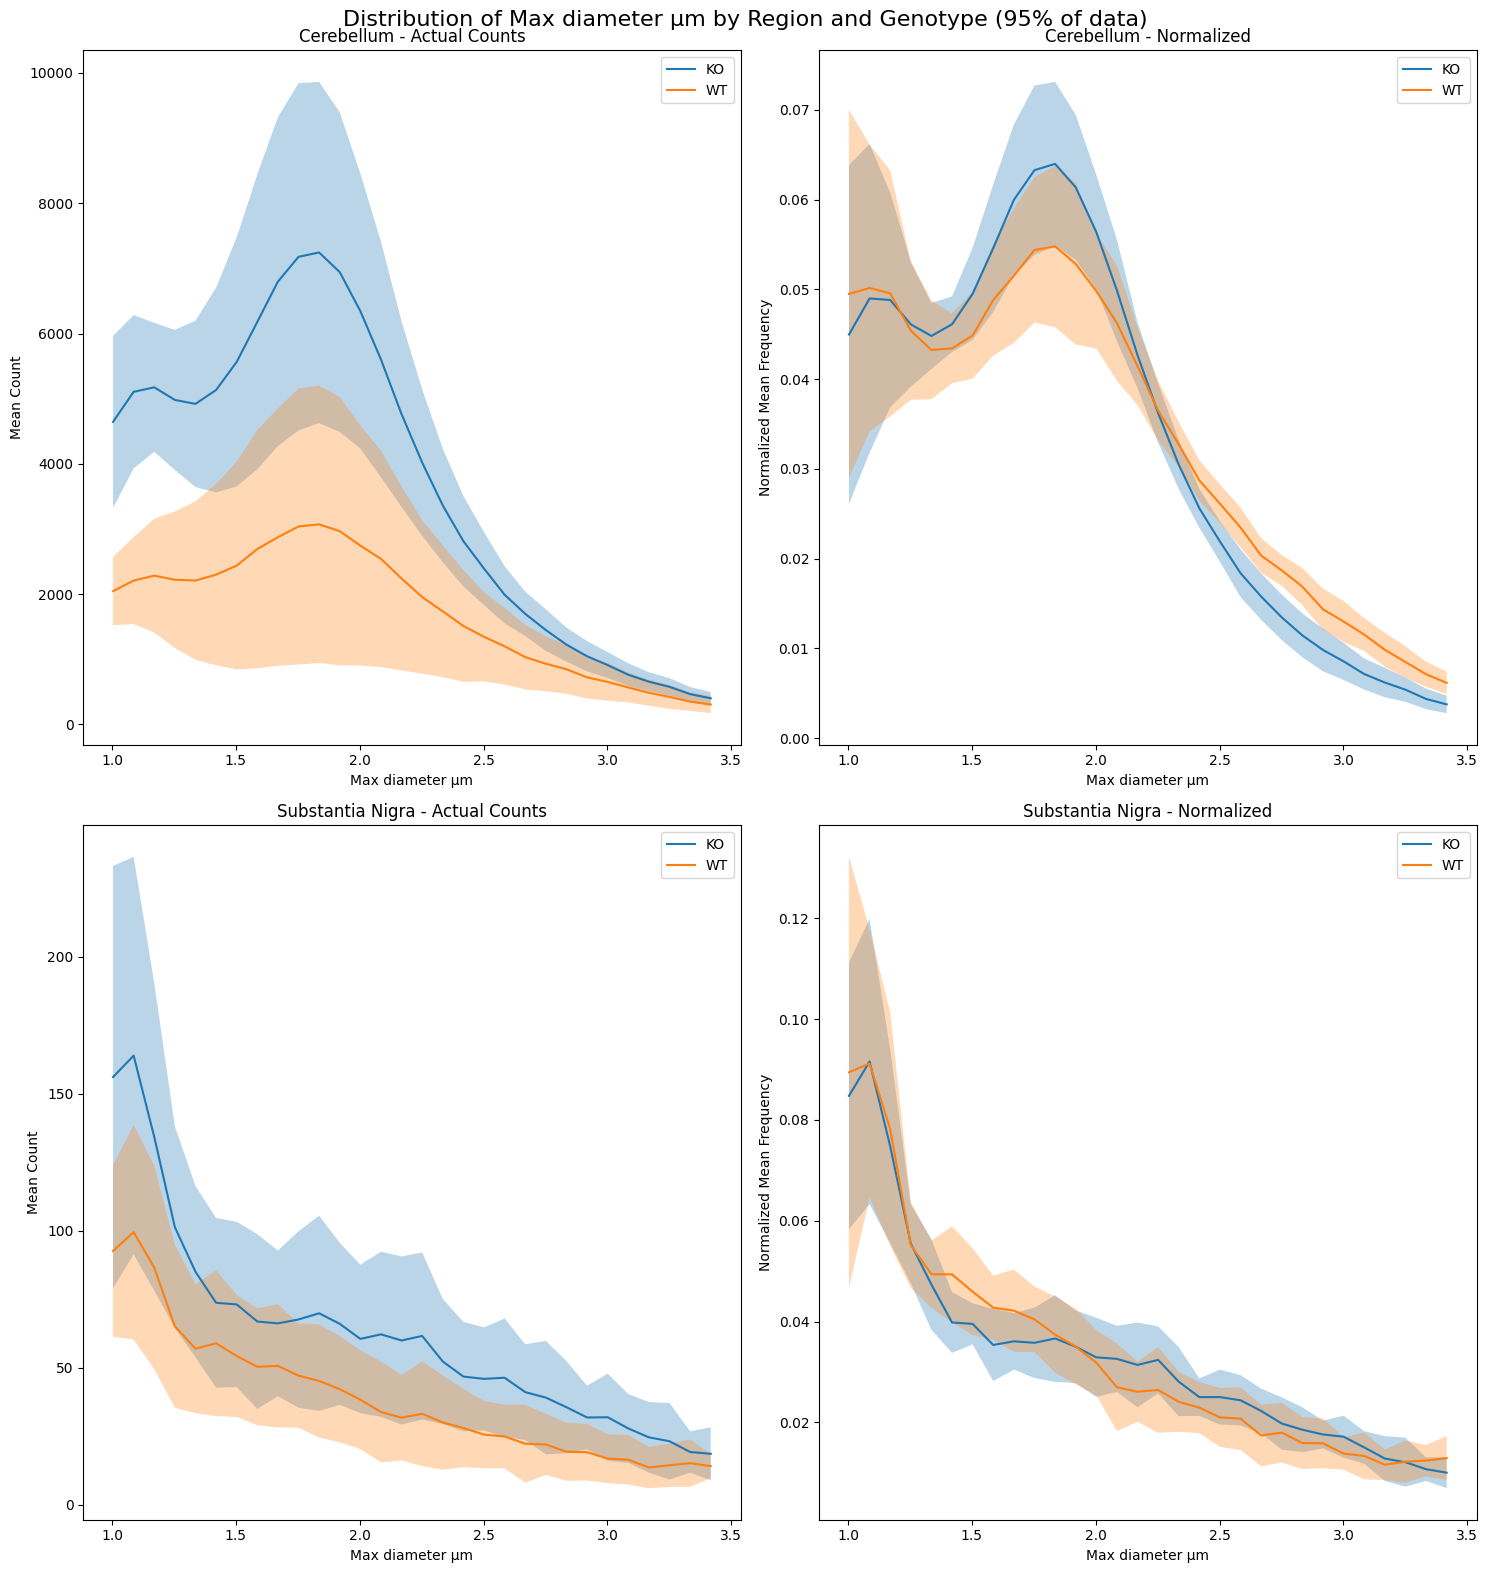

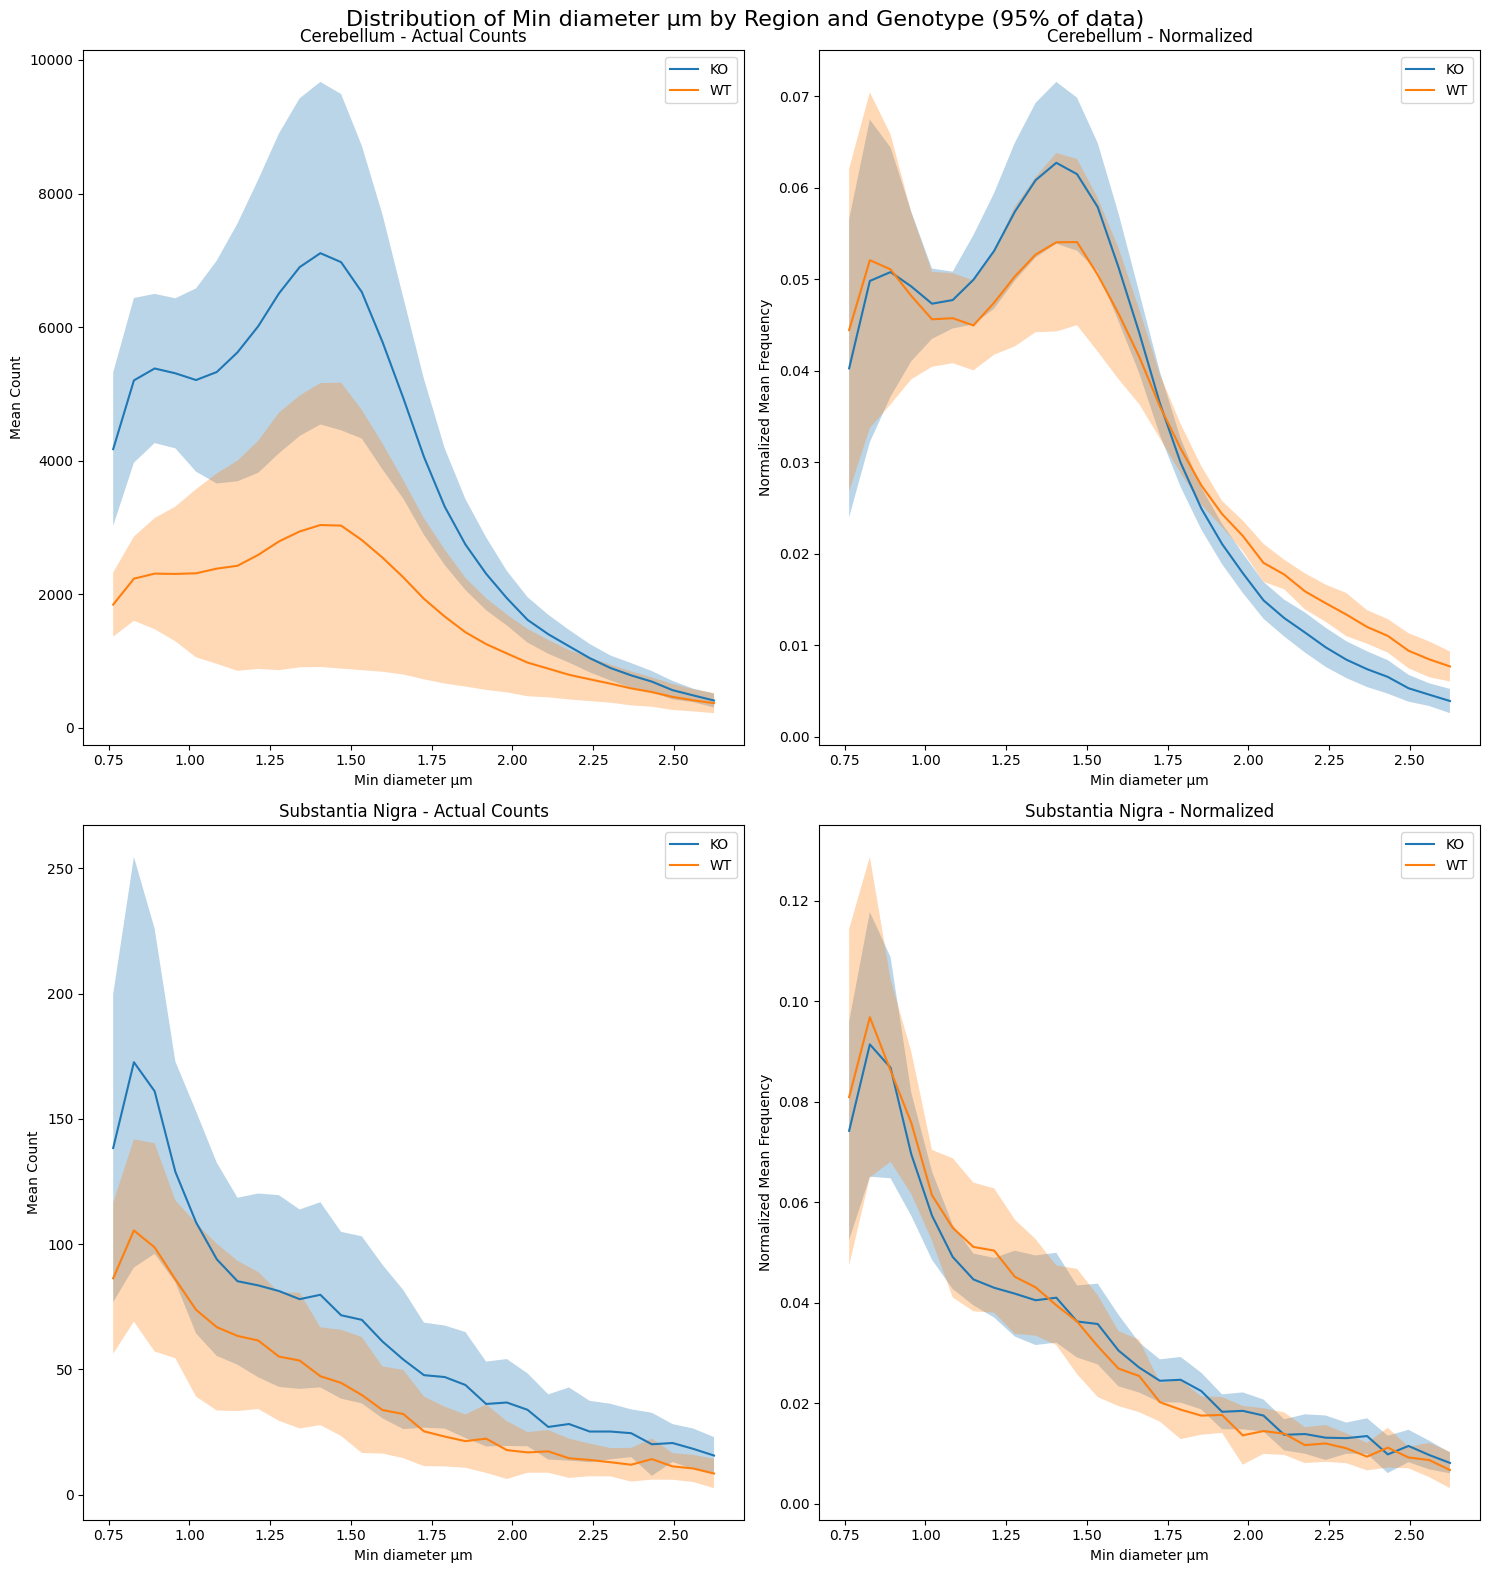

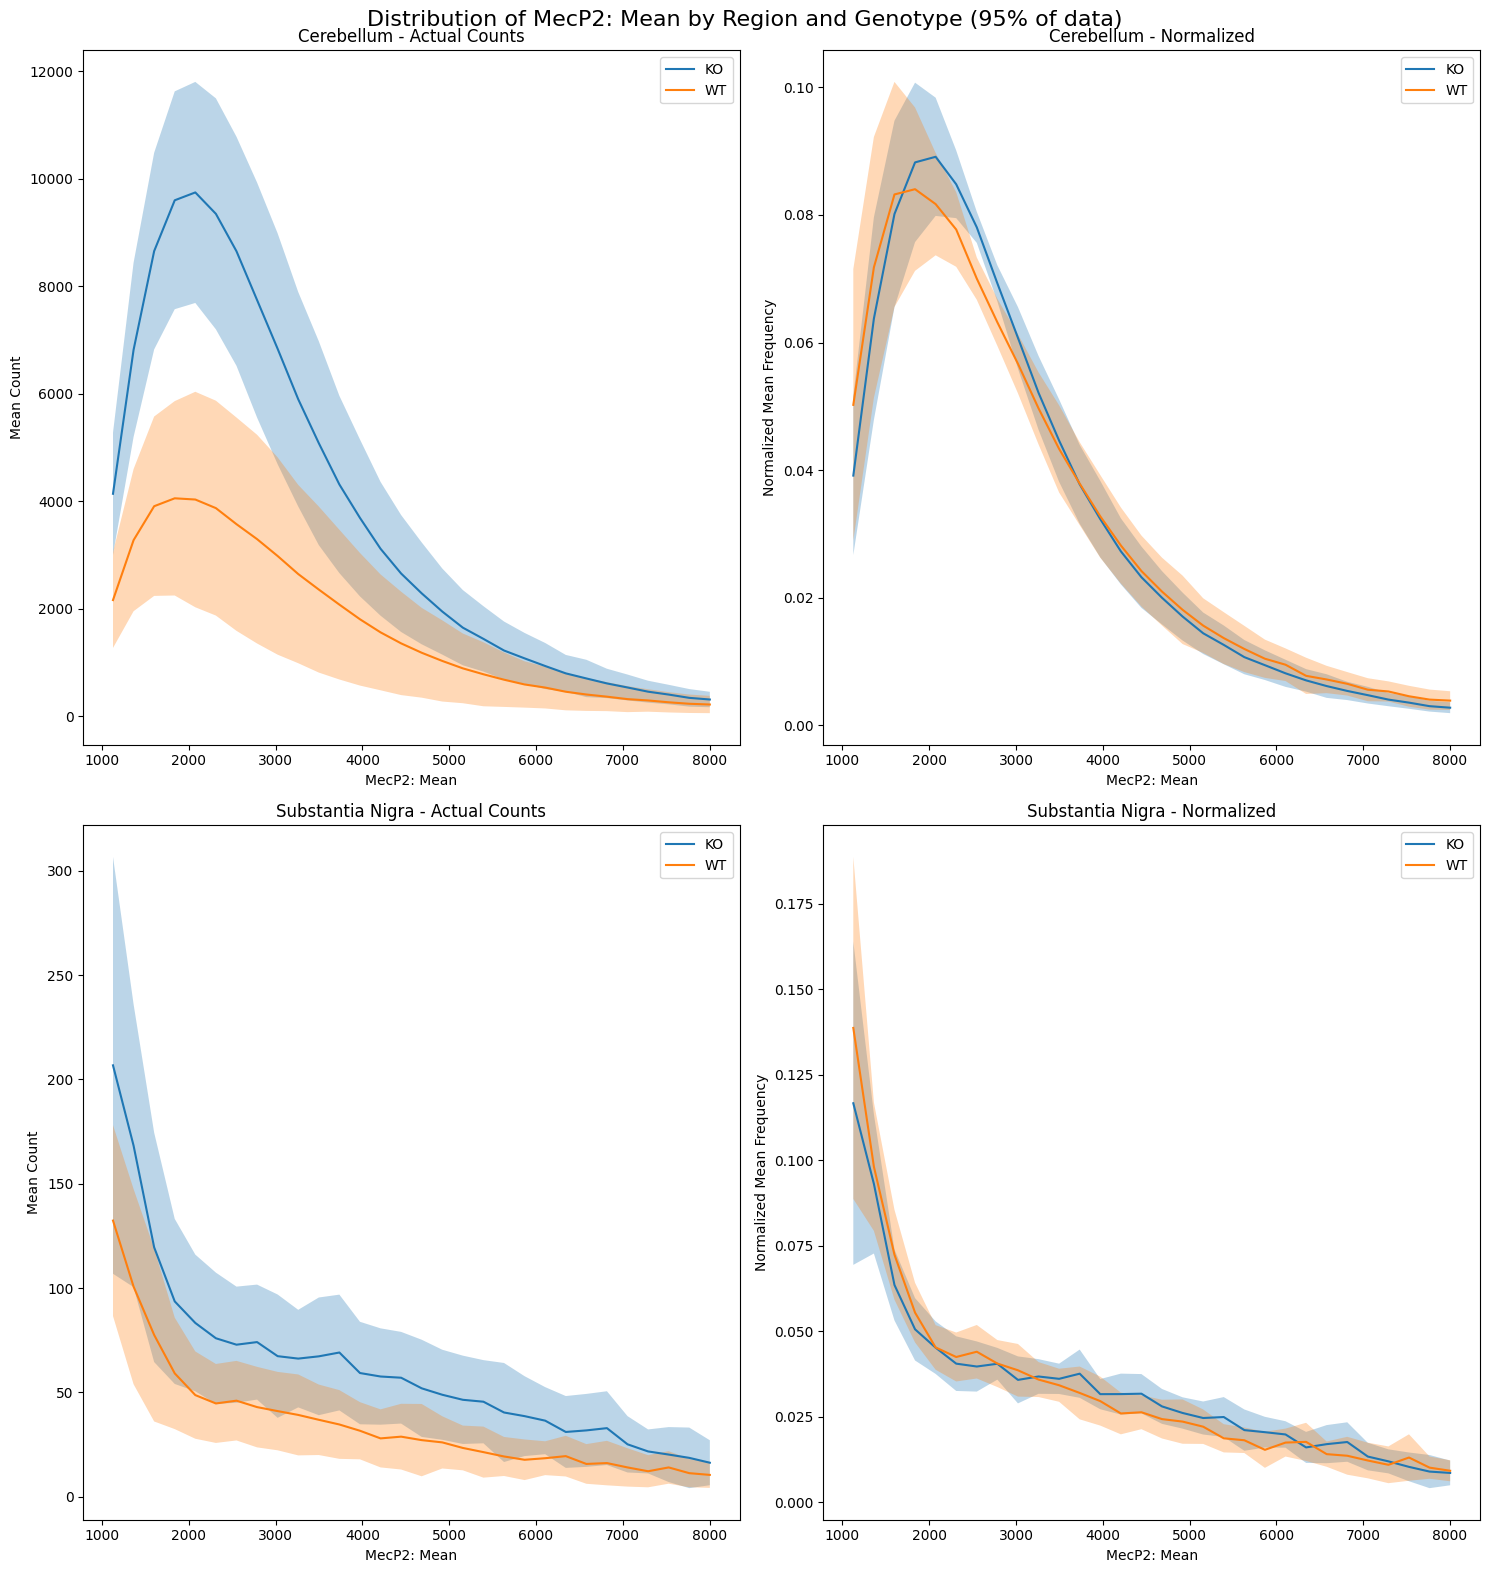

Script execution completed.


In [7]:
# Define the features we want to analyze
features = ['Area µm^2', 'Length µm', 'Circularity', 'Solidity', 'Max diameter µm', 'Min diameter µm', 'MecP2: Mean']

# Function to calculate histograms
def calculate_histograms(data, bins):
    # Create a histogram of the data using the specified bins
    hist, _ = np.histogram(data, bins=bins)
    # Return both the actual counts and the normalized histogram (probabilities)
    return hist, hist / np.sum(hist)

# Function to get the data range for a specified percentile
def get_data_range(data, percentile=95):
    # Calculate the lower bound of the range
    lower = np.percentile(data, (100 - percentile) / 2)
    # Calculate the upper bound of the range
    upper = np.percentile(data, 100 - (100 - percentile) / 2)
    return lower, upper

# Main function to plot distributions by region
def plot_distributions_by_region(data, feature, n_bins=30, percentile=95):
    # Get the global data range for the specified percentile
    lower, upper = get_data_range(data[feature], percentile)

    # Create equally spaced bins within the specified range
    bins = np.linspace(lower, upper, n_bins + 1)

    # Get unique regions and genotypes from the data
    regions = data['Region'].unique()
    genotypes = data['Genotype'].unique()

    # Create a figure with subplots: 2 columns, and as many rows as there are regions
    fig, axs = plt.subplots(len(regions), 2, figsize=(15, 8 * len(regions)))
    # Set an overall title for the figure
    fig.suptitle(f'Distribution of {feature} by Region and Genotype ({percentile}% of data)', fontsize=16)

    # Loop through each region
    for i, region in enumerate(regions):
        # Filter data for the current region
        region_data = data[data['Region'] == region]

        # Initialize dictionaries to store histograms for each genotype
        actual_histograms = {}
        normalized_histograms = {}

        # Calculate histograms for each genotype in this region
        for genotype in genotypes:
            # Filter data for the current genotype
            genotype_data = region_data[region_data['Genotype'] == genotype]
            animal_hists_actual = []
            animal_hists_norm = []

            # Calculate histograms for each animal in this genotype
            for _, animal_data in genotype_data.groupby('Animal'):
                hist_actual, hist_norm = calculate_histograms(animal_data[feature], bins)
                animal_hists_actual.append(hist_actual)
                animal_hists_norm.append(hist_norm)

            # Store the histograms for this genotype
            actual_histograms[genotype] = np.array(animal_hists_actual)
            normalized_histograms[genotype] = np.array(animal_hists_norm)

        # Calculate mean and standard deviation of histograms for each genotype
        mean_hists_actual = {genotype: np.mean(hists, axis=0) for genotype, hists in actual_histograms.items()}
        std_hists_actual = {genotype: np.std(hists, axis=0) for genotype, hists in actual_histograms.items()}
        mean_hists_norm = {genotype: np.mean(hists, axis=0) for genotype, hists in normalized_histograms.items()}
        std_hists_norm = {genotype: np.std(hists, axis=0) for genotype, hists in normalized_histograms.items()}

        # Calculate the center of each bin for plotting
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Plot actual counts
        ax_actual = axs[i, 0]  # Left subplot for actual counts
        for genotype, mean_hist in mean_hists_actual.items():
            # Plot the mean histogram for this genotype
            ax_actual.plot(bin_centers, mean_hist, label=genotype)
            # Add shaded area for standard deviation
            ax_actual.fill_between(bin_centers,
                                   mean_hist - std_hists_actual[genotype],
                                   mean_hist + std_hists_actual[genotype],
                                   alpha=0.3)

        # Set labels and title for the actual counts plot
        ax_actual.set_xlabel(feature)
        ax_actual.set_ylabel('Mean Count')
        ax_actual.set_title(f'{region} - Actual Counts')
        ax_actual.legend()

        # Plot normalized frequencies
        ax_norm = axs[i, 1]  # Right subplot for normalized frequencies
        for genotype, mean_hist in mean_hists_norm.items():
            # Plot the mean normalized histogram for this genotype
            ax_norm.plot(bin_centers, mean_hist, label=genotype)
            # Add shaded area for standard deviation
            ax_norm.fill_between(bin_centers,
                                 mean_hist - std_hists_norm[genotype],
                                 mean_hist + std_hists_norm[genotype],
                                 alpha=0.3)

        # Set labels and title for the normalized frequencies plot
        ax_norm.set_xlabel(feature)
        ax_norm.set_ylabel('Normalized Mean Frequency')
        ax_norm.set_title(f'{region} - Normalized')
        ax_norm.legend()

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    # Save the figure as a PNG file
    plt.savefig(f"{feature.replace(' ', '_').replace('^', '')}_{percentile}percentile_distributions_by_region.png")
    # Display the plot
    plt.show()
    # Close the figure to free up memory
    plt.close()

# Create plots for each feature
for feature in features:
    plot_distributions_by_region(filtered_df, feature, percentile=95)

print("Script execution completed.")

### Generate the area distribution comparison between conditions grouped by region

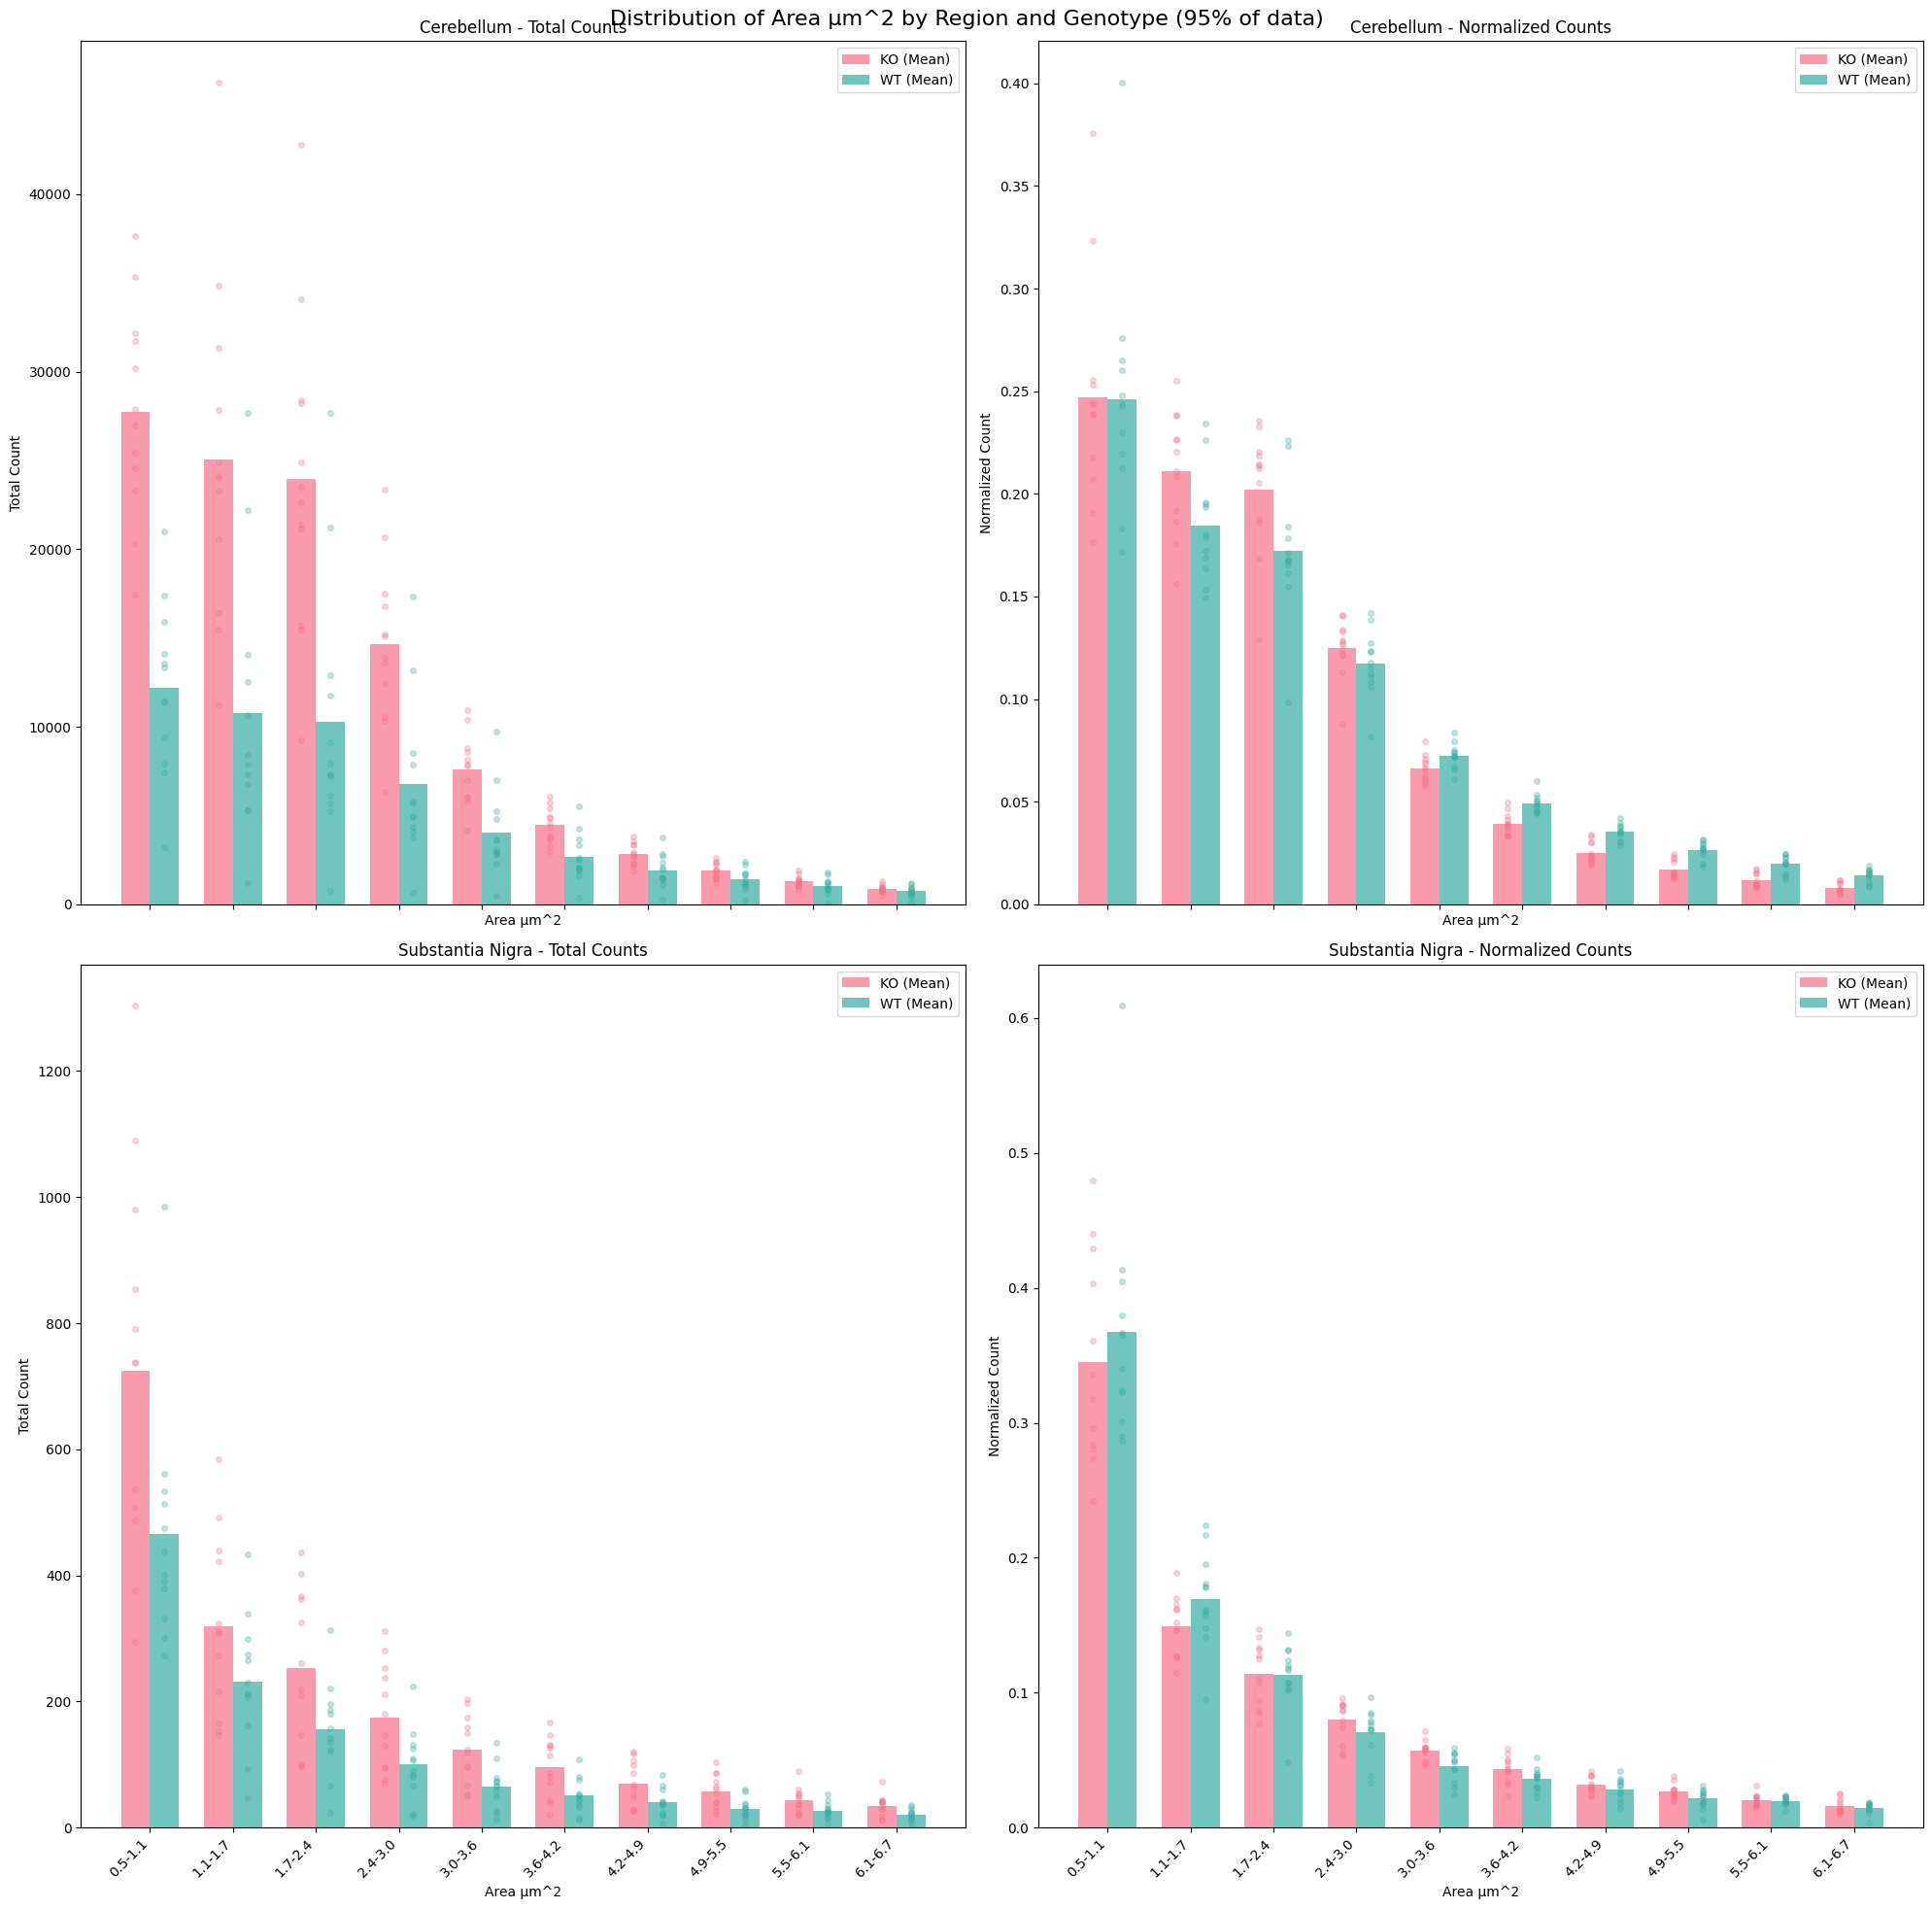

Detailed area comparison script with side-by-side bars execution completed.


In [8]:
def compare_area_bins(data, n_bins=10, percentile=95):
    # Filter for the 'Area µm^2' feature
    area_data = data['Area µm^2']

    # Get the data range for the specified percentile
    lower, upper = np.percentile(area_data, [(100 - percentile) / 2, 100 - (100 - percentile) / 2])

    # Create equally spaced bins within the specified range
    bins = np.linspace(lower, upper, n_bins + 1)

    # Get unique regions and genotypes from the data
    regions = data['Region'].unique()
    genotypes = data['Genotype'].unique()

    # Create a figure with subplots: two rows for each region (total counts and normalized counts)
    fig, axs = plt.subplots(len(regions), 2, figsize=(20, 10 * len(regions)), sharex='col')
    fig.suptitle(f'Distribution of Area µm^2 by Region and Genotype ({percentile}% of data)', fontsize=16)

    # Create a color palette for genotypes
    color_palette = sns.color_palette("husl", n_colors=len(genotypes))

    for i, region in enumerate(regions):
        region_data = data[data['Region'] == region]

        bin_counts = {genotype: [] for genotype in genotypes}
        bin_counts_normalized = {genotype: [] for genotype in genotypes}

        for genotype in genotypes:
            genotype_data = region_data[region_data['Genotype'] == genotype]
            for _, animal_data in genotype_data.groupby('Animal'):
                hist, _ = np.histogram(animal_data['Area µm^2'], bins=bins)
                bin_counts[genotype].append(hist)
                bin_counts_normalized[genotype].append(hist / len(animal_data))

        # Convert to numpy arrays for easier manipulation
        for genotype in genotypes:
            bin_counts[genotype] = np.array(bin_counts[genotype])
            bin_counts_normalized[genotype] = np.array(bin_counts_normalized[genotype])

        # Plot total counts
        ax_total = axs[i, 0]
        ax_norm = axs[i, 1]

        x = np.arange(n_bins)
        width = 0.35  # the width of the bars

        for j, genotype in enumerate(genotypes):
            # Plot mean total counts
            mean_counts = np.mean(bin_counts[genotype], axis=0)
            ax_total.bar(x + j*width, mean_counts, width, alpha=0.7, color=color_palette[j], label=f'{genotype} (Mean)')

            # Plot individual animal data points
            for animal_counts in bin_counts[genotype]:
                ax_total.plot(x + j*width, animal_counts, 'o', color=color_palette[j], alpha=0.3, markersize=4)

            # Plot mean normalized counts
            mean_norm_counts = np.mean(bin_counts_normalized[genotype], axis=0)
            ax_norm.bar(x + j*width, mean_norm_counts, width, alpha=0.7, color=color_palette[j], label=f'{genotype} (Mean)')

            # Plot individual animal normalized data points
            for animal_norm_counts in bin_counts_normalized[genotype]:
                ax_norm.plot(x + j*width, animal_norm_counts, 'o', color=color_palette[j], alpha=0.3, markersize=4)

        # Set labels and title
        for ax in [ax_total, ax_norm]:
            ax.set_xlabel('Area µm^2')
            ax.set_xticks(x + width / 2)
            ax.set_xticklabels([f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(n_bins)], rotation=45, ha='right')
            ax.legend()

        ax_total.set_ylabel('Total Count')
        ax_norm.set_ylabel('Normalized Count')
        ax_total.set_title(f'{region} - Total Counts')
        ax_norm.set_title(f'{region} - Normalized Counts')

    plt.tight_layout()
    plt.savefig(f"Area_comparison_detailed_sidebyside_{percentile}percentile.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Use the function
compare_area_bins(filtered_df, n_bins=10, percentile=95)

print("Detailed area comparison script with side-by-side bars execution completed.")